<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Visión Computacional </em><br>
    <em>Profesor: Takeshi Asahi </em><br>

</div>

# Machine Learning Avanzado
*22 de Abril de 2024*

#### Integrantes: 
` Giuseppe Lavarello`

## 1. Objetivo

El objetivo principal de esta tarea consiste en implementar una serie de pasos que concluyan en la creación de un modelo de clasificación para el conjunto de datos **Brain Tumor MRI Dataset**, disponible en **Kaggle**.

1. Se eligió este dataset por su relevancia en el tratamiento de pacientes con tumores cerebrales. Este es un problema importante, pues la identificación de los tumores facilita la determinación del tratamiento con mayores probabilidades de éxito.
2. El propósito es identificar los tipos de tumores presentes en las imágenes obtenidas mediante resonancia magnética, entre: tumores pituitarios, gliomas, meningiomas o la ausencia de tumor.
3. Pasos a seguir:
    - Diseñar un flujo de procesamiento: adquisición de imágenes, preprocesamiento, procesamiento de imágenes, cálculo de mediciones y almacenamiento.
    - Implementar un sistema de clasificación mediante CNN.
    - Medir los tiempos de ejecución del procesamiento de las imágenes de prueba.
    - Hacer un resumen de los resultados del procesamiento, en particular de sus métricas.


# 2. Carga de datos

In [2]:


# manejo datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# visualización y gráficos
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
# Os y glob para manejo de archivos
import os
from glob import glob

# Modelos
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D

# Configuración de TensorFlow para evitar advertencias y errores de GPU
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
absl.logging.set_verbosity('error')  # or 'fatal'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

#medicion de ejecucion
import time

2025-05-08 19:07:14.414786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746745634.429890   81322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746745634.434117   81322 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746745634.445343   81322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746745634.445364   81322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746745634.445365   81322 computation_placer.cc:177] computation placer alr

**Decisión**  
En esta tarea, a diferencia de la anterior, se creará un dataframe que contenga el `path` y la `clase` de cada imagen. Esto permitirá realizar el preprocesamiento directamente con la librería `ImageDataGenerator` de Keras.


In [3]:
def load_paths(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes}) # DataFrame con rutas y etiquetas
    return tr_df

In [4]:
tr_df = load_paths(r'./data/Training')
ts_df = load_paths(r'./data/Testing')


In [5]:
# Visualización de las clases y sus conteos
def plot_class_distribution(df):
    """ Visualiza la distribución de clases en el conjunto de entrenamiento.
    Args:
        tr_df (DataFrame): DataFrame que contiene las rutas de las imágenes y sus etiquetas.
    """

    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    ax = sns.countplot(data=df, x='Class', order=tr_df['Class'].value_counts().index)

    ax.set_title('Distribución de Clases en el Conjunto de Entrenamiento')
    ax.set_xlabel('Clases')
    ax.set_ylabel('Conteo')
    plt.xticks(rotation=25)


    # añadir cantidad dentro de las barras
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()//2), 
                    ha='center', 
                    va='bottom', 
                    fontsize=15, 
                    color='w', 
                    weight='bold', 
                    rotation=90, 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    #añadir total de imágenes arriba a la derecha 
    total = len(df)
    ax.annotate(f'Total de imagenes: {total}', 
                (0.9, 0.90), 
                xycoords='axes fraction', 
                ha='right', 
                va='top', 
                fontsize=15, 
                color='black',  
                rotation=0, 
                xytext=(0, 5), 
                textcoords='offset points')
    plt.tight_layout()
    plt.show()

**Decisión**  
Dado que no hay datos de validación, separamos aleatoriamente los datos de prueba en dos grupos: 50% para validación y 50% para prueba.


In [6]:
val_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=1122, stratify=ts_df['Class'])

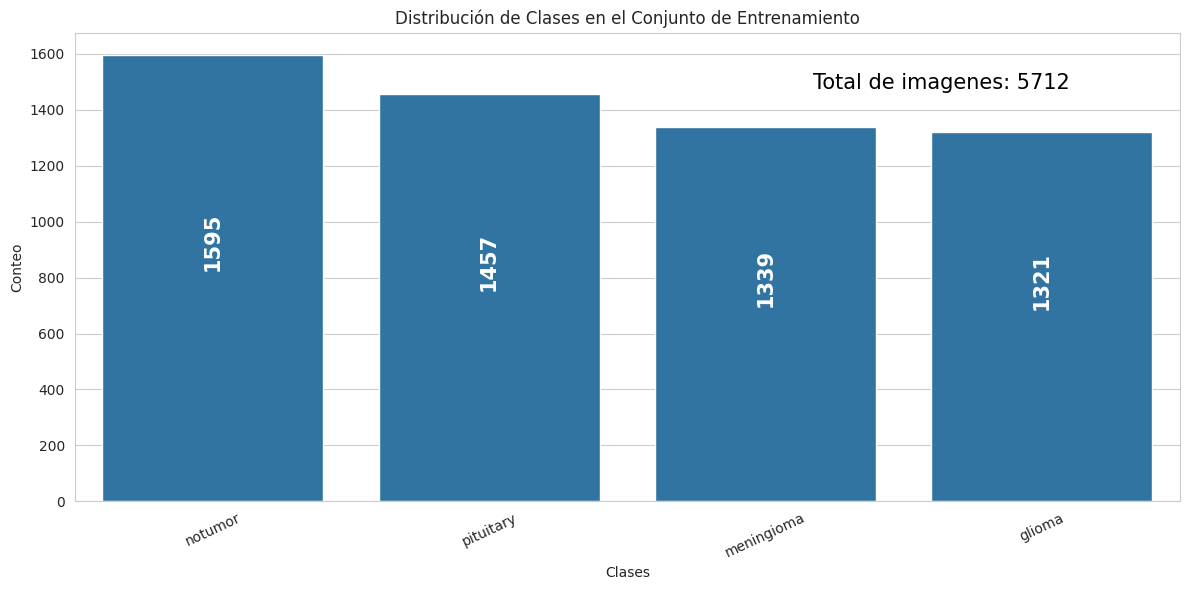

In [7]:
plot_class_distribution(tr_df)

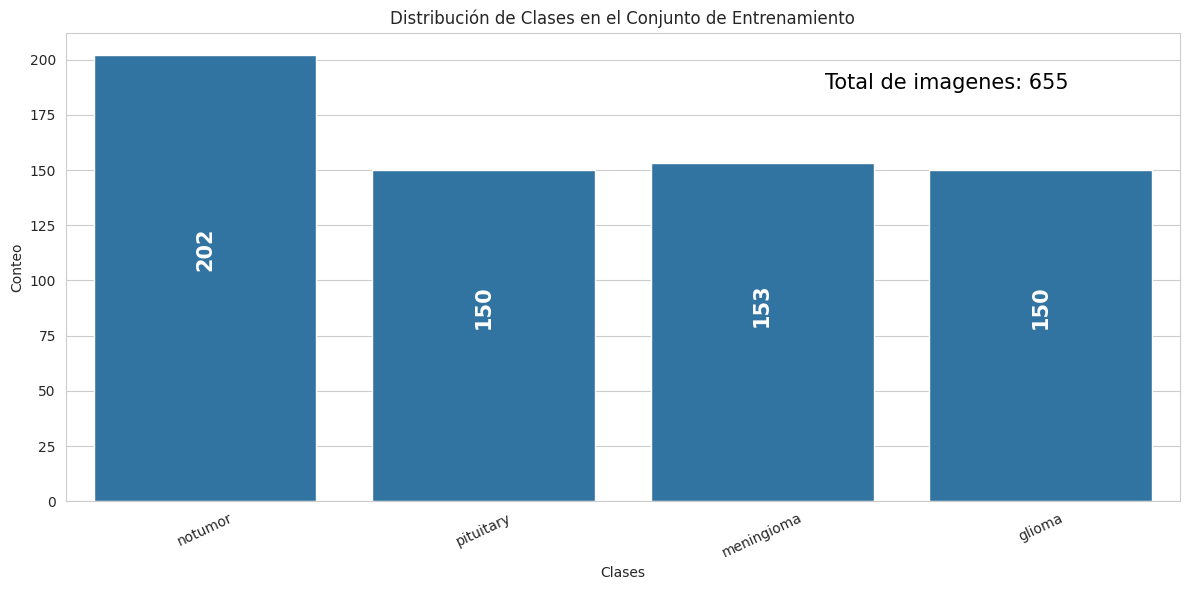

In [8]:
plot_class_distribution(val_df)

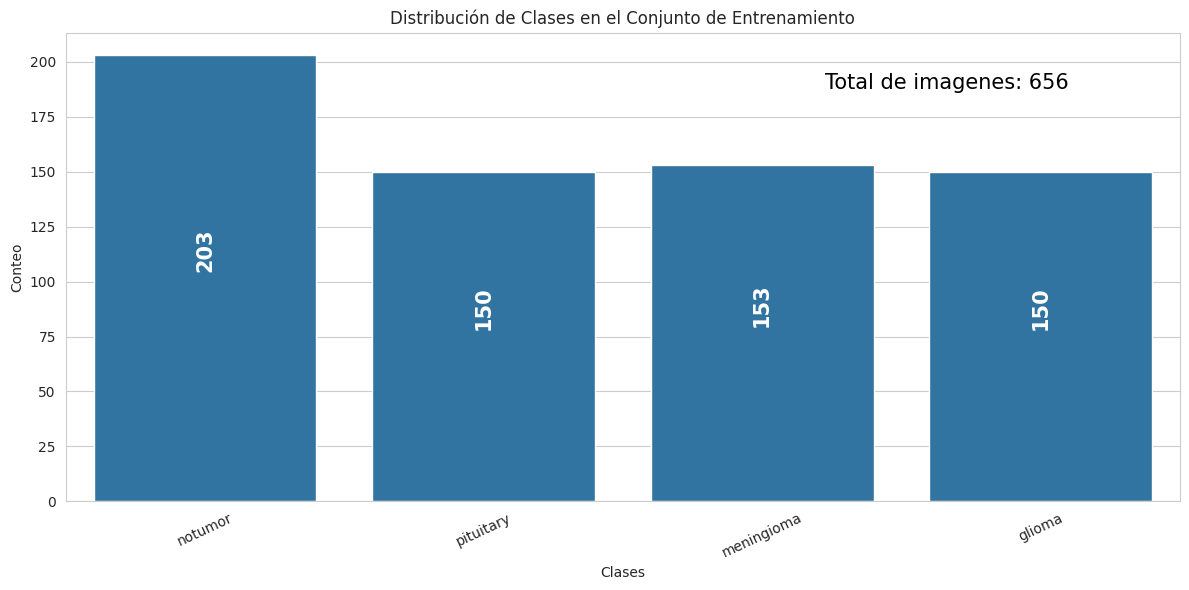

In [9]:
plot_class_distribution(ts_df)

**Importante**  
Aunque existe un pequeño desbalance en los datos a favor de la clase `notumor`, este no es lo suficientemente significativo como para justificar una limpieza más profunda en esta etapa. Sin embargo, en las siguientes iteraciones de esta tarea se trabajará para tratar de obtener mejores resultados.


In [10]:
tr_df.describe()

,Class Path,Class
count,5712,5712
unique,5712,4
top,./data/Training/pituitary/Tr-pi_1440.jpg,notumor
freq,1,1595


In [11]:
val_df.describe()

,Class Path,Class
count,655,655
unique,655,4
top,./data/Testing/pituitary/Te-pi_0297.jpg,notumor
freq,1,202


In [12]:
ts_df.describe()

,Class Path,Class
count,656,656
unique,656,4
top,./data/Testing/meningioma/Te-me_0112.jpg,notumor
freq,1,203


# 3. Preprocesamiento
Se crean los manipuladores de imagen y se realizan tres tratamientos distintos para generar diferentes conjuntos de datos. 

1. En la primera iteración, las imágenes son reescaladas y convertidas a escala de grises.



In [13]:

batch_size = 32
img_size = (256, 256)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    color_mode='grayscale', # cambio a greyscale

                                  )

valid_gen = _gen.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        color_mode='grayscale', # cambio a greyscale

                                     )

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', batch_size=16,
                                    target_size=img_size, # reescalado de imagenes)
                                    color_mode='grayscale', # cambio a greyscale
                                    shuffle=False)




Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


2. En la segunda iteración, las imágenes son rotadas aleatoriamente entre 0 y 90 grados.


In [14]:
_gen_rotated = ImageDataGenerator(rescale=1/255, rotation_range=90)

tr_gen_rotated = _gen_rotated.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    color_mode='grayscale', # cambio a greyscale
                                    class_mode='categorical', # clasificacion multiclase
                                  )

valid_gen_rotated = _gen_rotated.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        color_mode='grayscale', # cambio a greyscale
                                        class_mode='categorical', # clasificacion multiclase
                                     )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


3. En la tercera iteración, las imágenes son rotadas aleatoriamente entre 0 y 90 grados, y trasladadas también de forma aleatoria hasta un 20% tanto en alto como en ancho.


In [15]:
_gen_rotated_shifted = ImageDataGenerator(rescale=1/255, rotation_range=90,width_shift_range=0.2, height_shift_range=0.2)

tr_gen_rotated_shifted = _gen_rotated_shifted.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    color_mode='grayscale', # cambio a greyscale
                                    class_mode='categorical', # clasificacion multiclase
                                  )

valid_gen_rotated_shifted = _gen_rotated_shifted.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        color_mode='grayscale', # cambio a greyscale
                                        class_mode='categorical', # clasificacion multiclase
                                     )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


## 3.1 Muestra de imagenes

1. Las imagenes se presentan con buen contraste y escala. Es importante notar que el corte de la imagen esta en diferentes orientaciones, lo que puede confundir al modelo.

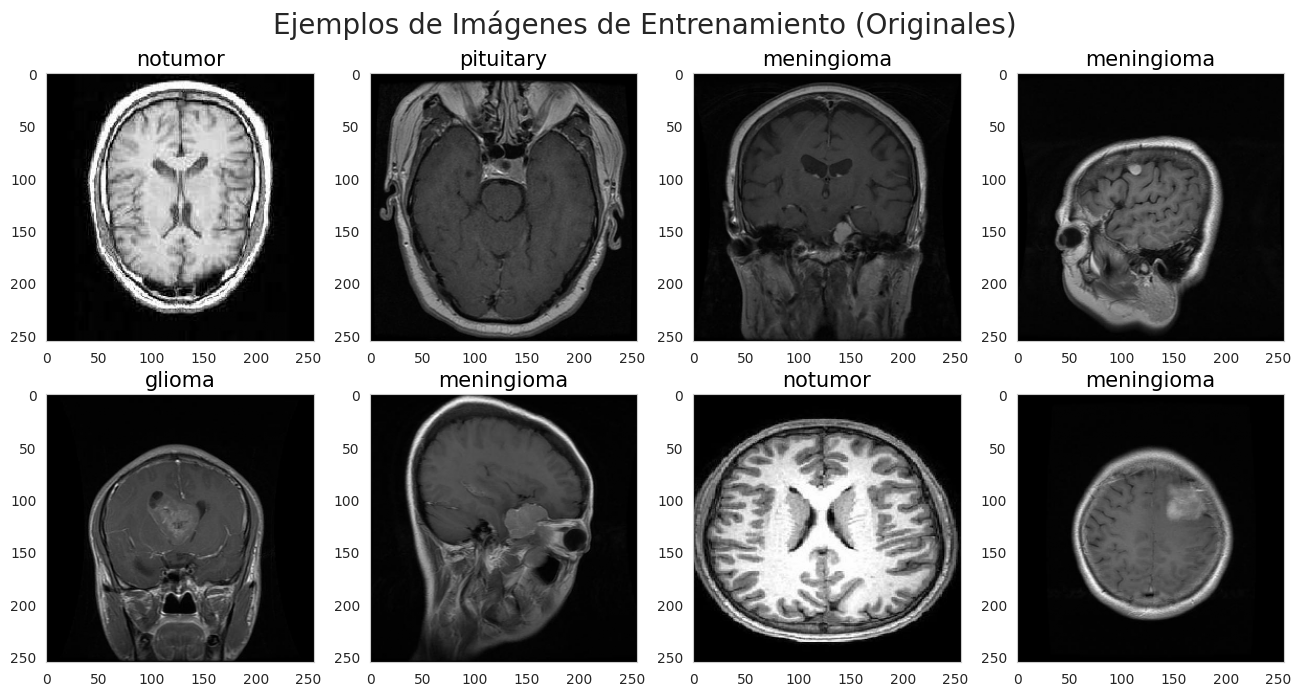

In [16]:

classes = list(tr_gen.class_indices.keys())
images, labels = next(tr_gen)

def plot_images(images, labels, classes, title):
    plt.figure(figsize=(16, 16))
    plt.suptitle(title, fontsize=20, y=0.92)
    for i, (image, label) in enumerate(zip(images, labels)):
        if i >= 8:
            break
        plt.subplot(4,4, i + 1)
        plt.imshow(image, cmap='gray')
        class_name = classes[np.argmax(label)]
        plt.title(class_name, color='k', fontsize=15)
        plt.grid(False)

    plt.show()
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento (Originales)')


2. 

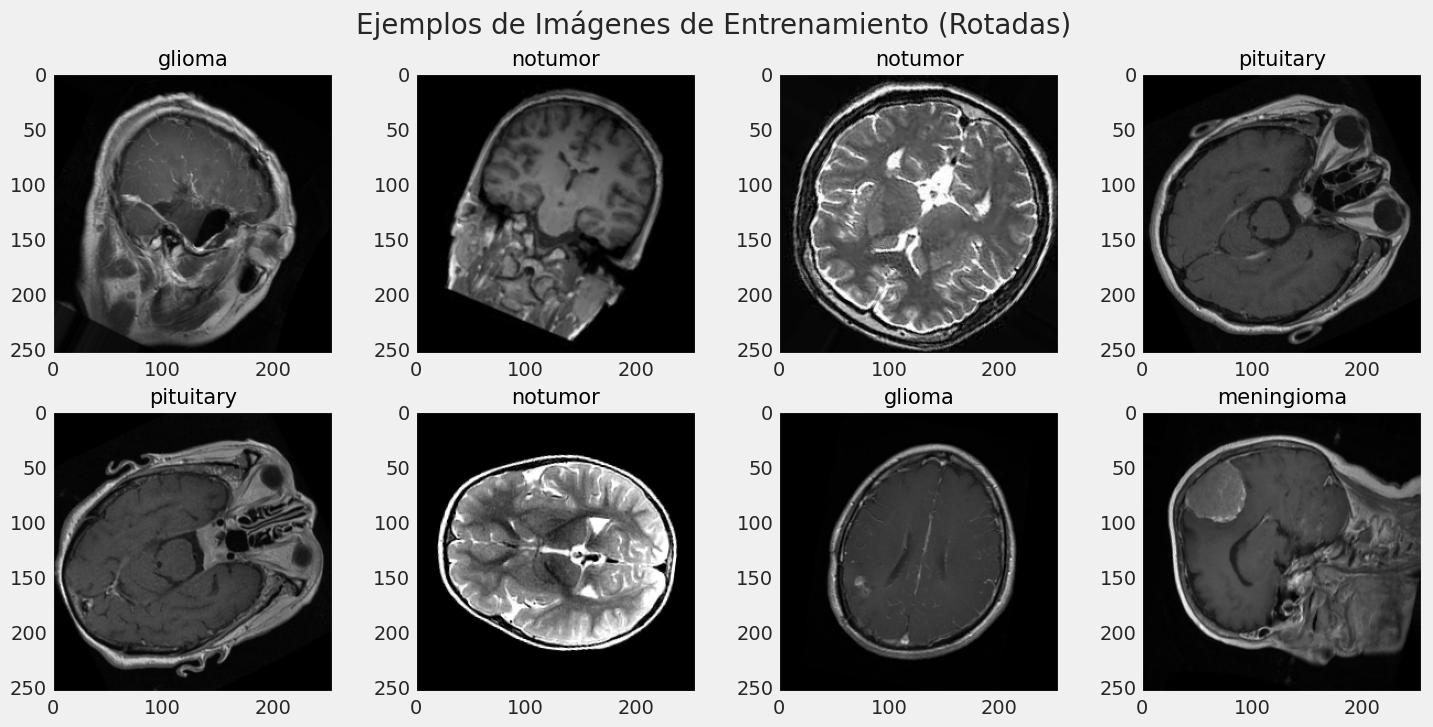

In [59]:
images, labels = next(tr_gen_rotated)
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento (Rotadas)')

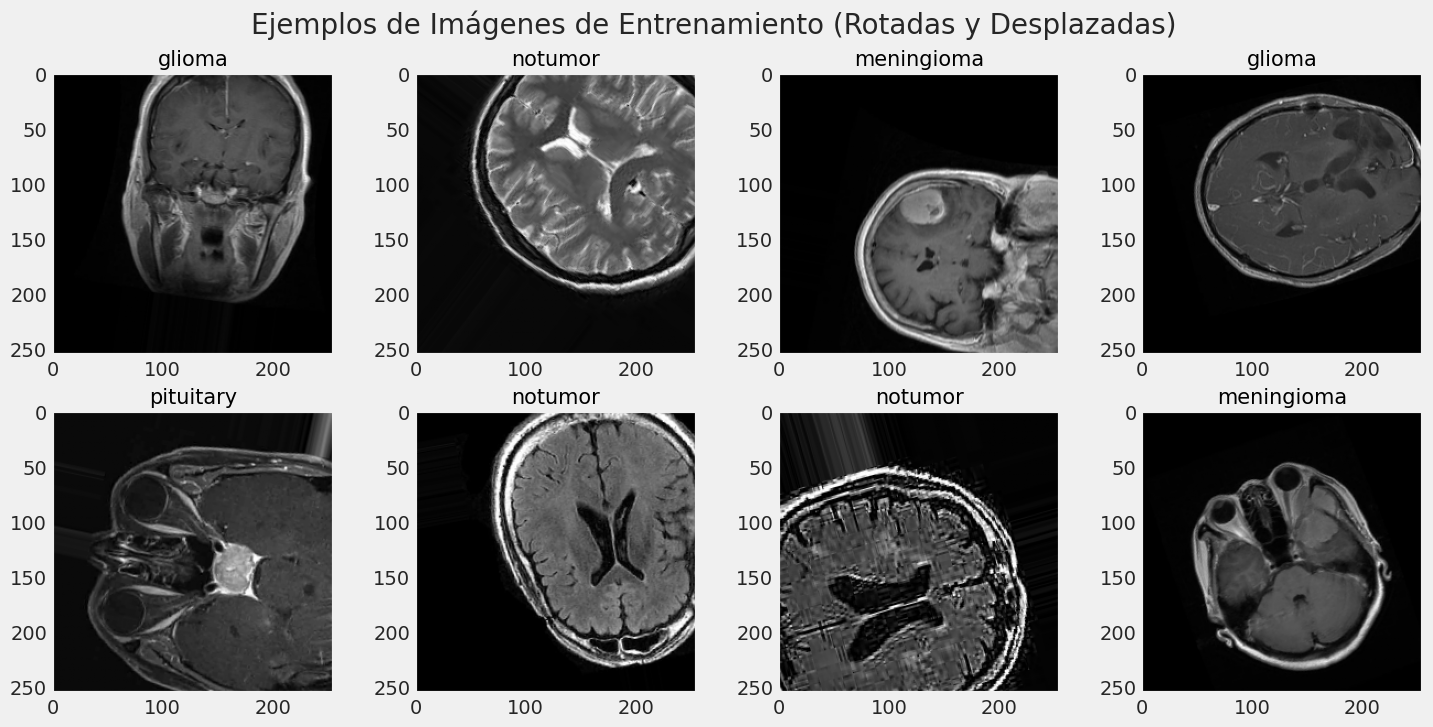

In [60]:
images, labels = next(tr_gen_rotated_shifted)
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento (Rotadas y Desplazadas)')

In [19]:
# Definición del modelo

epocas = 10
img_shape=(256,256,1)
  
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())    
    
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()




I0000 00:00:1746745669.349340   81322 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,395,524 (226.58 MB)

 Trainable params: 59,394,628 (226.57 MB)

 Non-trainable params: 896 (3.50 KB)

In [20]:

hist = model.fit(tr_gen,
                     epochs=epocas,
                     validation_data=valid_gen,
                     shuffle= False)




Epoch 1/10


I0000 00:00:1746745673.400107   81425 service.cc:152] XLA service 0x7f6540004940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746745673.400147   81425 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-08 19:07:53.524972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746745673.803378   81425 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-08 19:07:55.455054: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1022', 12 bytes spill stores, 12 bytes spill loads

2025-05-08 19:07:55.507514: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1022'

179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.6964 - loss: 4.3517 - precision: 0.7040 - recall: 0.6924 - val_accuracy: 0.2290 - val_loss: 15.9246 - val_precision: 0.2290 - val_recall: 0.2290
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8583 - loss: 0.6986 - precision: 0.8598 - recall: 0.8565 - val_accuracy: 0.3023 - val_loss: 21.7272 - val_precision: 0.3023 - val_recall: 0.3023
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.9290 - loss: 0.2680 - precision: 0.9301 - recall: 0.9277 - val_accuracy: 0.5298 - val_loss: 2.6214 - val_precision: 0.5375 - val_recall: 0.5252
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9392 - loss: 0.2155 - precision: 0.9396 - recall: 0.9387 - val_accuracy: 0.8824 - val_loss: 0.4646 - val_precision: 0.8819 - val_recall: 0.8779
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9525 - loss: 0.1677 - precision: 0.9525 - recall: 0.9513 - val_accuracy: 0.9237 - val_lo

In [21]:
def plot_training_history(hist):
    """ Visualiza la historia de entrenamiento del modelo.
    Args:
        hist (History): Historia de entrenamiento del modelo.
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    tr_per = hist.history['precision']
    tr_recall = hist.history['recall']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    val_per = hist.history['val_precision']
    val_recall = hist.history['val_recall']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_precision = np.argmax(val_per)
    per_highest = val_per[index_precision]
    index_recall = np.argmax(val_recall)
    recall_highest = val_recall[index_recall]

    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'
    per_label = f'Best epoch = {str(index_precision + 1)}'
    recall_label = f'Best epoch = {str(index_recall + 1)}'


    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')


    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label, zorder=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label, zorder=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label, zorder=2)
    plt.title('Precision and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label, zorder=2)
    plt.title('Recall and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    #make yticks percentage
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.show()

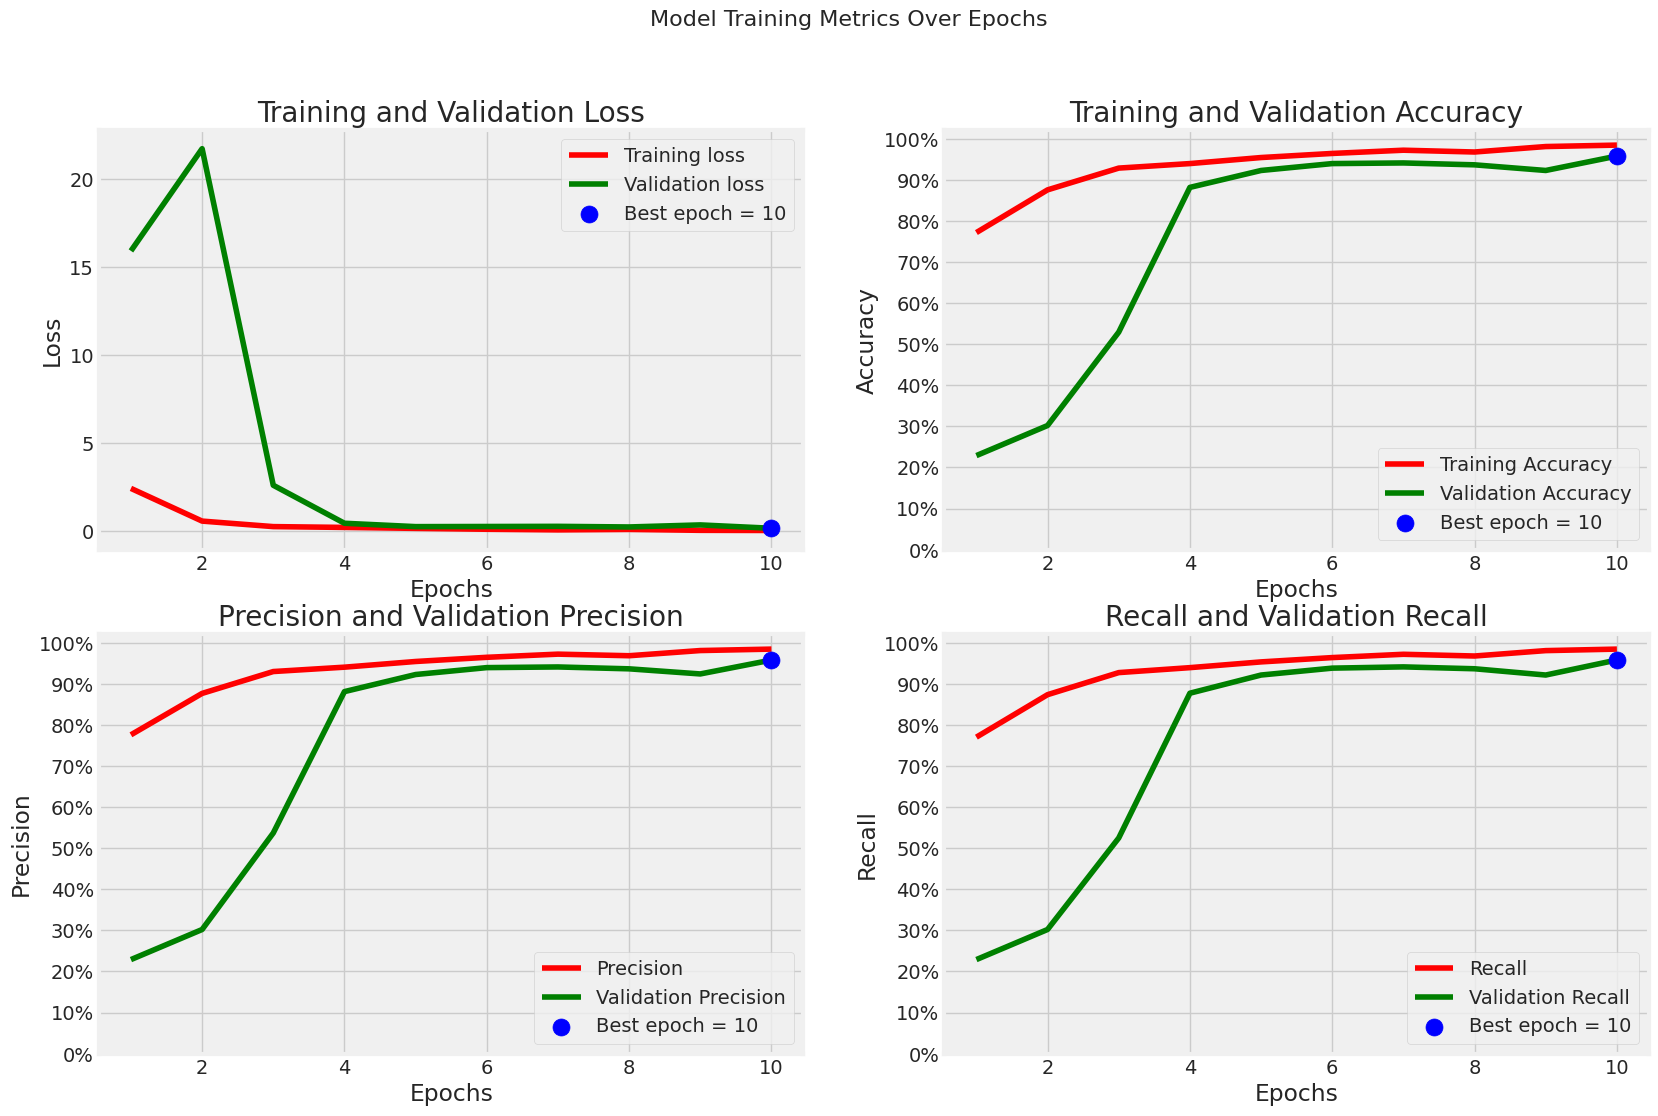

In [22]:
plot_training_history(hist)

In [23]:
model_rotated = Sequential()

model_rotated.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,1)))
model_rotated.add(BatchNormalization())
model_rotated.add(MaxPooling2D())

model_rotated.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model_rotated.add(BatchNormalization())
model_rotated.add(MaxPooling2D())

model_rotated.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model_rotated.add(BatchNormalization())
model_rotated.add(MaxPooling2D())    
    
model_rotated.add(Flatten())

model_rotated.add(Dense(256, activation='relu'))
model_rotated.add(Dense(128, activation='relu'))
model_rotated.add(Dense(64, activation='relu'))
model_rotated.add(Dense(4, activation='softmax'))

model_rotated.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model_rotated.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,395,524 (226.58 MB)

 Trainable params: 59,394,628 (226.57 MB)

 Non-trainable params: 896 (3.50 KB)

In [24]:

hist_rotated = model.fit(tr_gen_rotated,
                     epochs=epocas,
                     validation_data=valid_gen_rotated,
                     shuffle= False)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.7133 - loss: 1.7542 - precision: 0.7173 - recall: 0.7100 - val_accuracy: 0.7603 - val_loss: 0.8095 - val_precision: 0.7680 - val_recall: 0.7481
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.8151 - loss: 0.6122 - precision: 0.8237 - recall: 0.8074 - val_accuracy: 0.7649 - val_loss: 0.6714 - val_precision: 0.7766 - val_recall: 0.7588
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.8567 - loss: 0.4717 - precision: 0.8642 - recall: 0.8496 - val_accuracy: 0.7588 - val_loss: 0.7483 - val_precision: 0.7686 - val_recall: 0.7557
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 219ms/step - accuracy: 0.8563 - loss: 0.4717 - precision: 0.8668 - recall: 0.8529 - val_accuracy: 0.8198 - val_loss: 0.5899 - val_precision: 0.8261 - val_recall: 0.8122
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.8661 - loss: 0.4048 - precision: 0.8731 - recall: 0.8572 - val_accuracy: 0.8244

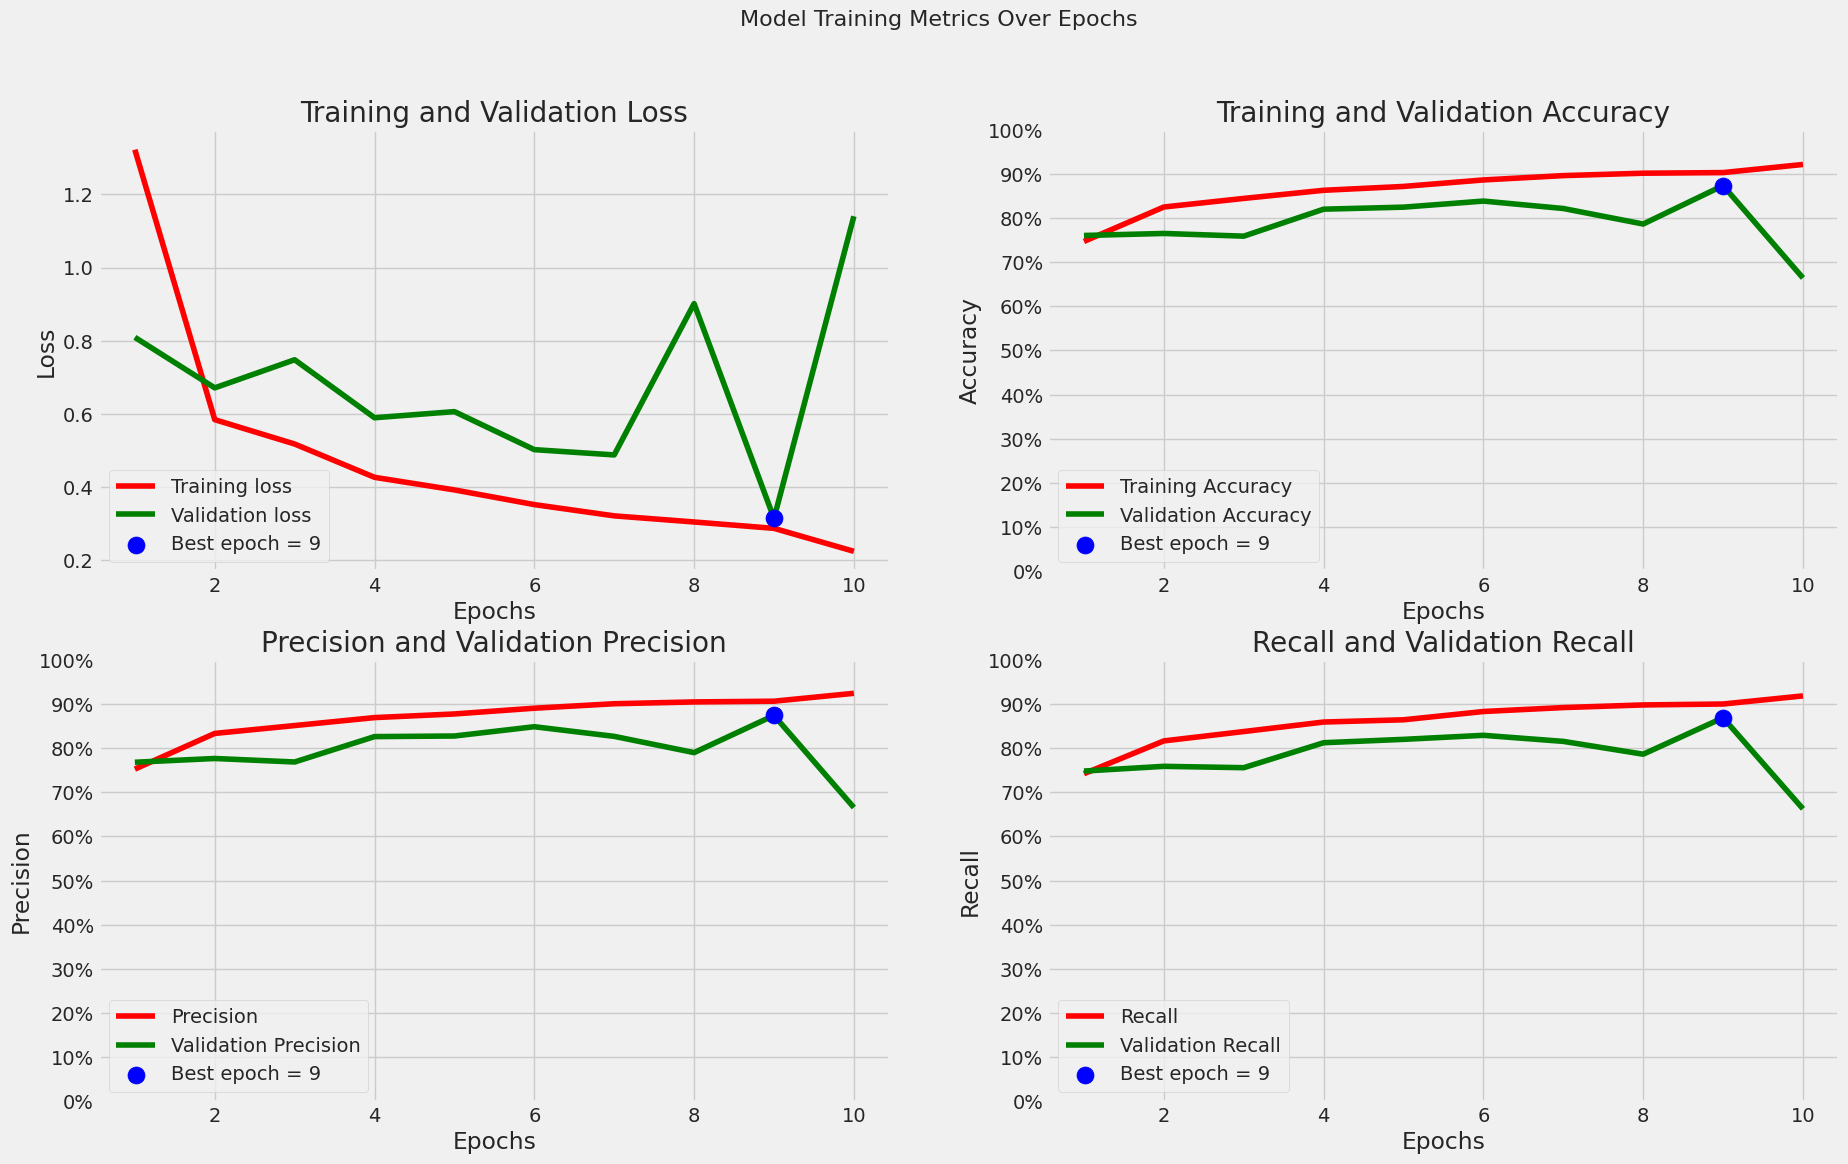

In [25]:
plot_training_history(hist_rotated)

In [26]:
model_rotated_shifted = Sequential()

model_rotated_shifted.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,1)))
model_rotated_shifted.add(BatchNormalization())
model_rotated_shifted.add(MaxPooling2D())

model_rotated_shifted.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model_rotated_shifted.add(BatchNormalization())
model_rotated_shifted.add(MaxPooling2D())

model_rotated_shifted.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model_rotated_shifted.add(BatchNormalization())
model_rotated_shifted.add(MaxPooling2D())    
    
model_rotated_shifted.add(Flatten())

model_rotated_shifted.add(Dense(256, activation='relu'))
model_rotated_shifted.add(Dense(128, activation='relu'))
model_rotated_shifted.add(Dense(64, activation='relu'))
model_rotated_shifted.add(Dense(4, activation='softmax'))

model_rotated_shifted.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model_rotated_shifted.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,395,524 (226.58 MB)

 Trainable params: 59,394,628 (226.57 MB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
hist_rotated_shifted = model.fit(tr_gen_rotated_shifted,
                     epochs=epocas,
                     validation_data=valid_gen_rotated_shifted,
                     shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.7162 - loss: 1.0348 - precision: 0.7366 - recall: 0.7019 - val_accuracy: 0.7160 - val_loss: 0.7955 - val_precision: 0.7368 - val_recall: 0.6840
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.7993 - loss: 0.6090 - precision: 0.8158 - recall: 0.7796 - val_accuracy: 0.7542 - val_loss: 0.6895 - val_precision: 0.7701 - val_recall: 0.7313
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.8270 - loss: 0.5028 - precision: 0.8398 - recall: 0.8112 - val_accuracy: 0.7588 - val_loss: 0.6537 - val_precision: 0.7695 - val_recall: 0.7389
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.8216 - loss: 0.4717 - precision: 0.8338 - recall: 0.8116 - val_accuracy: 0.6809 - val_loss: 1.3544 - val_precision: 0.6854 - val_recall: 0.6718
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.8458 - loss: 0.4436 - precision: 0.8534 - recall: 0.8325 - val_accuracy: 0.6794

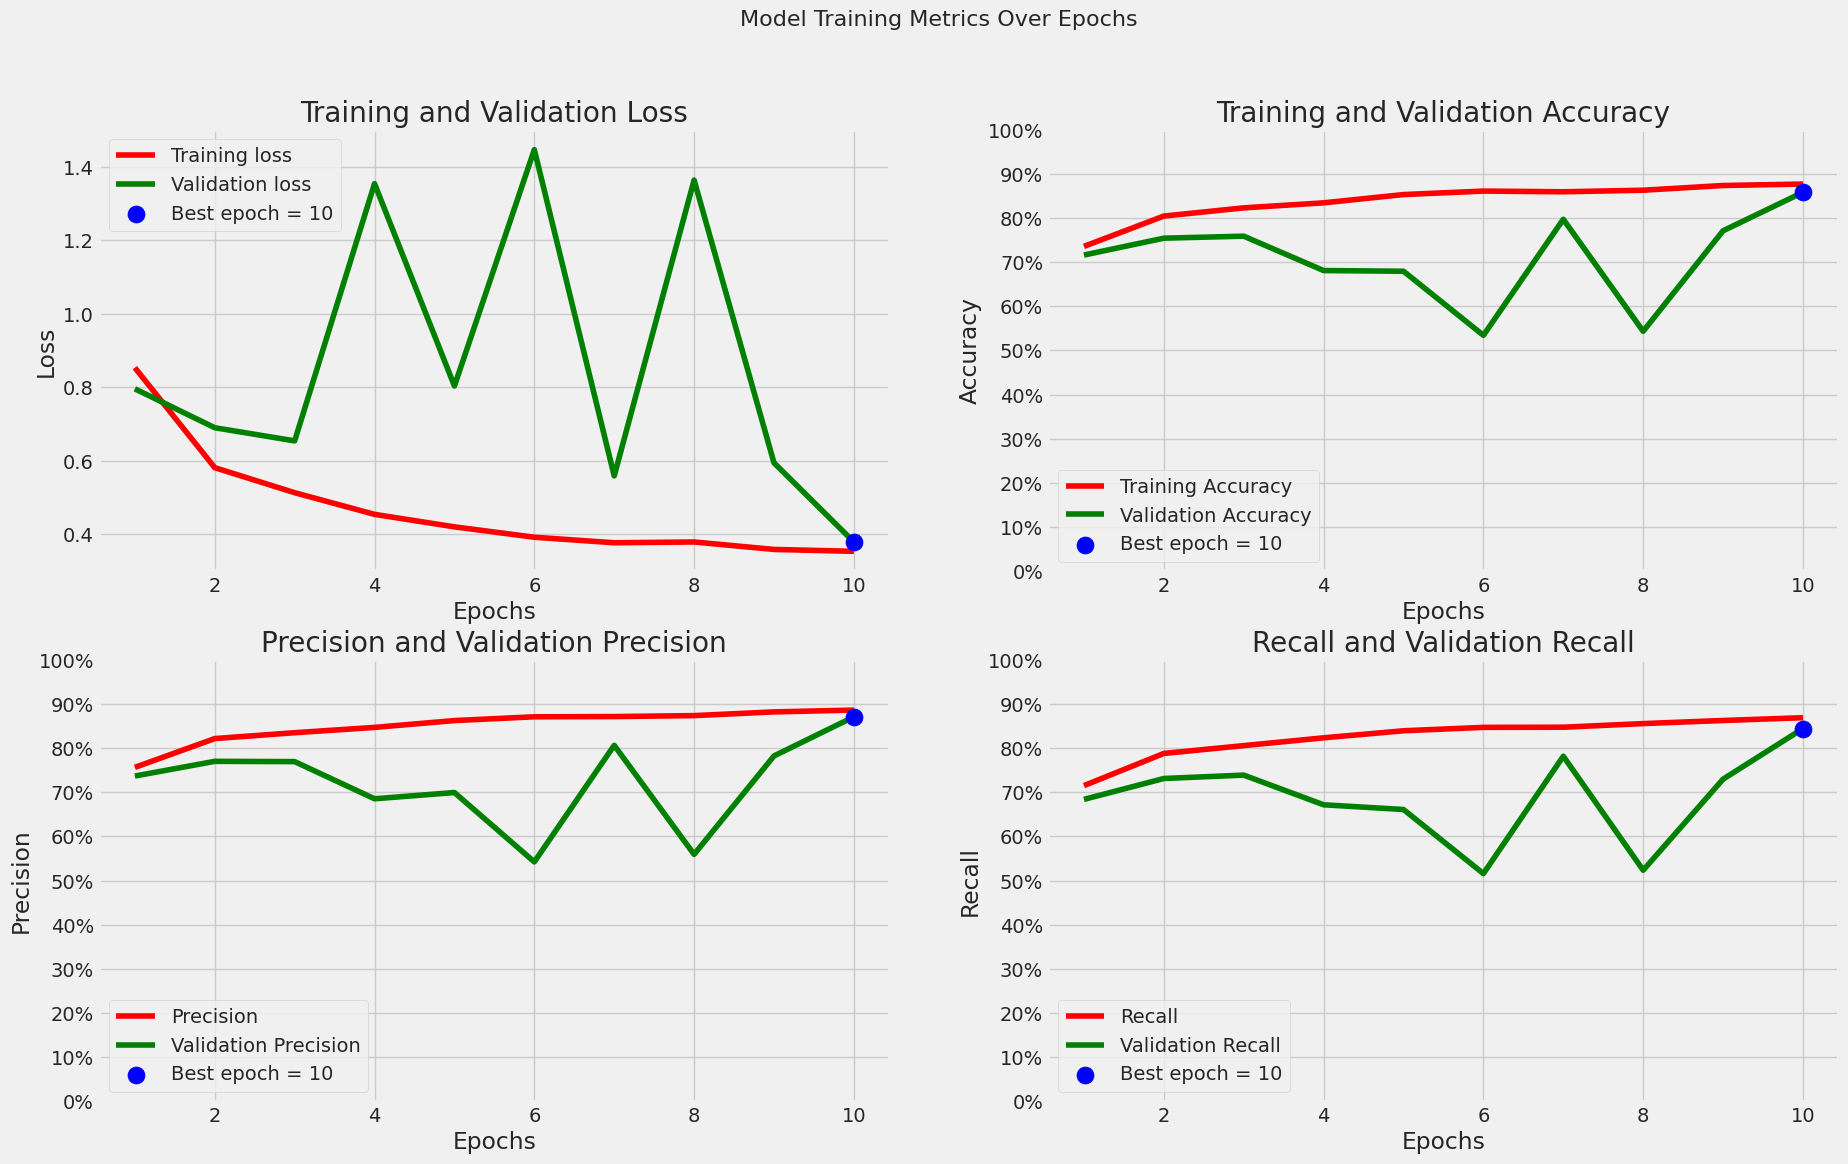

In [28]:
plot_training_history(hist_rotated_shifted)

In [43]:
repeticiones = 10
tiempo = []
for i in range(repeticiones):
    start_time = time.time()
    pred = model.predict(ts_gen)
    end_time = time.time()
    tiempo.append({"tiempo" :end_time - start_time})

df_tiempo = pd.DataFrame(tiempo)

y_pred = np.argmax(pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [44]:
tiempo_rotado = []
for i in range(repeticiones):
    start_time = time.time()
    pred_rotado = model_rotated.predict(ts_gen)
    end_time = time.time()
    tiempo_rotado.append({"tiempo_rotado" :end_time - start_time})

df_tiempo_rotado = pd.DataFrame(tiempo_rotado)

y_pred_rotado = np.argmax(pred_rotado, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [50]:
tiempo_rotado_shifted = []
for i in range(repeticiones):
    start_time = time.time()
    pred_rotado_shifted = model_rotated_shifted.predict(ts_gen)
    end_time = time.time()
    tiempo_rotado_shifted.append({"tiempo_rotado_shifted" :end_time - start_time})

df_tiempo_rotado_shifted = pd.DataFrame(tiempo_rotado_shifted)

y_pred_rotado_shifted = np.argmax(pred_rotado_shifted, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [51]:
total_muestras=len(ts_gen.filenames) # total de imagenes en el generador de test
steps= int((total_muestras/ts_gen.batch_size)//2) # pasos por epoca

In [52]:
df_tiempo_final = df_tiempo.join(df_tiempo_rotado, how='outer').join(df_tiempo_rotado_shifted, how='outer')
df_tiempo_final.head(10)

,tiempo,tiempo_rotado,tiempo_rotado_shifted
0,3.512522,2.301561,2.803408
1,2.359197,2.460248,2.242737
2,1.572513,2.412505,2.479874
3,2.585770,2.289388,2.480115
4,2.373569,2.270199,2.335164
5,2.364720,2.445912,2.416273
6,2.369224,1.780460,2.272849
7,2.346651,2.283438,2.447819
8,2.356252,2.379041,2.362031
9,2.336515,2.391680,1.651306


In [53]:
tiempo_mitad = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad = model_rotated.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad.append({"tiempo_mitad" :end_time - start_time})

df_tiempo_mitad = pd.DataFrame(tiempo_mitad)

y_pred_mitad = np.argmax(pred_mitad, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [54]:
tiempo_mitad_rotado = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad_rotado = model_rotated.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad_rotado.append({"tiempo_mitad_rotado" :end_time - start_time})

df_tiempo_mitad_rotado = pd.DataFrame(tiempo_mitad_rotado)

y_pred_mitad_rotado = np.argmax(pred_mitad_rotado, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [55]:
tiempo_mitad_rotado_shifted = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad_rotado_shifted = model_rotated.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad_rotado_shifted.append({"tiempo_mitad_rotado_shifted" :end_time - start_time})

df_tiempo_mitad_rotado_shifted = pd.DataFrame(tiempo_mitad_rotado_shifted)

y_pred_mitad_rotado_shifted = np.argmax(pred_mitad_rotado_shifted, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [56]:
df_tiempo_mitad_final = df_tiempo_mitad.join(df_tiempo_mitad_rotado, how='outer').join(df_tiempo_mitad_rotado_shifted, how='outer')
df_tiempo_final = df_tiempo_final.join(df_tiempo_mitad_final, how='outer')
df_tiempo_final.head(10)

,tiempo,tiempo_rotado,tiempo_rotado_shifted,tiempo_mitad,tiempo_mitad_rotado,tiempo_mitad_rotado_shifted
0,3.512522,2.301561,2.803408,1.569246,1.336746,1.320027
1,2.359197,2.460248,2.242737,1.269974,1.217020,1.350671
2,1.572513,2.412505,2.479874,1.268222,1.333028,1.340176
3,2.585770,2.289388,2.480115,1.201205,1.368447,1.303744
4,2.373569,2.270199,2.335164,1.215832,1.342181,1.185888
5,2.364720,2.445912,2.416273,1.261771,1.335594,1.181345
6,2.369224,1.780460,2.272849,1.372359,1.298395,1.274069
7,2.346651,2.283438,2.447819,1.372886,1.300684,1.317838
8,2.356252,2.379041,2.362031,1.316993,1.262121,1.287601
9,2.336515,2.391680,1.651306,1.324502,0.413231,1.337241


In [58]:
df_tiempo_final.describe()

,tiempo,tiempo_rotado,tiempo_rotado_shifted,tiempo_mitad,tiempo_mitad_rotado,tiempo_mitad_rotado_shifted
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.417693,2.301443,2.349157,1.317299,1.220745,1.289860
std,0.467519,0.195919,0.290464,0.106017,0.287139,0.060736
min,1.572513,1.780460,1.651306,1.201205,0.413231,1.181345
25%,2.349051,2.284926,2.288428,1.263384,1.271190,1.277452
50%,2.361958,2.340301,2.389152,1.293483,1.316856,1.310791
75%,2.372482,2.407299,2.471860,1.360395,1.336458,1.332937
max,3.512522,2.460248,2.803408,1.569246,1.368447,1.350671


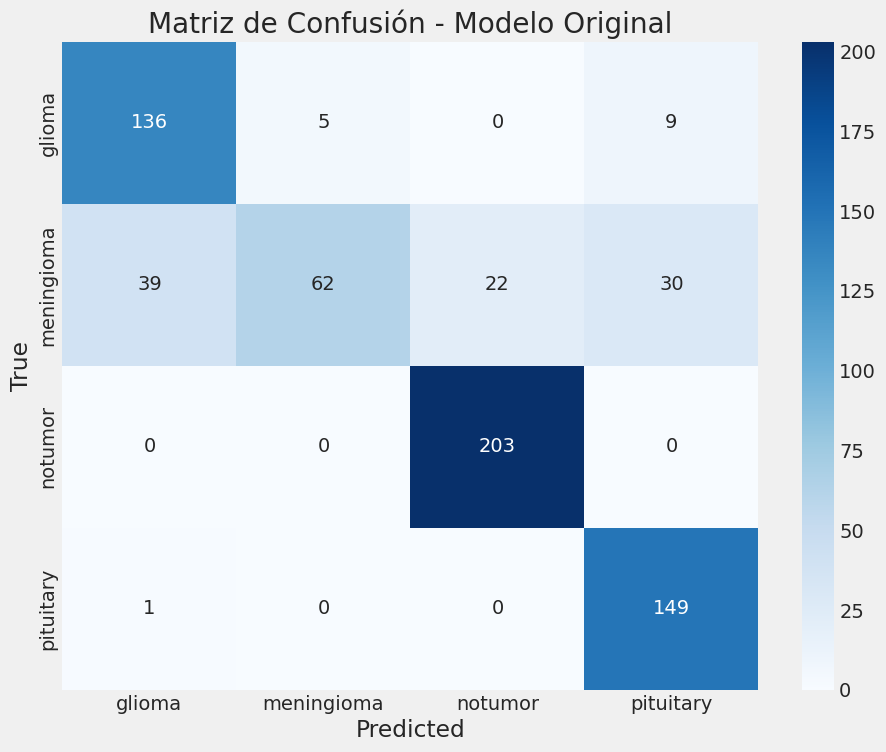

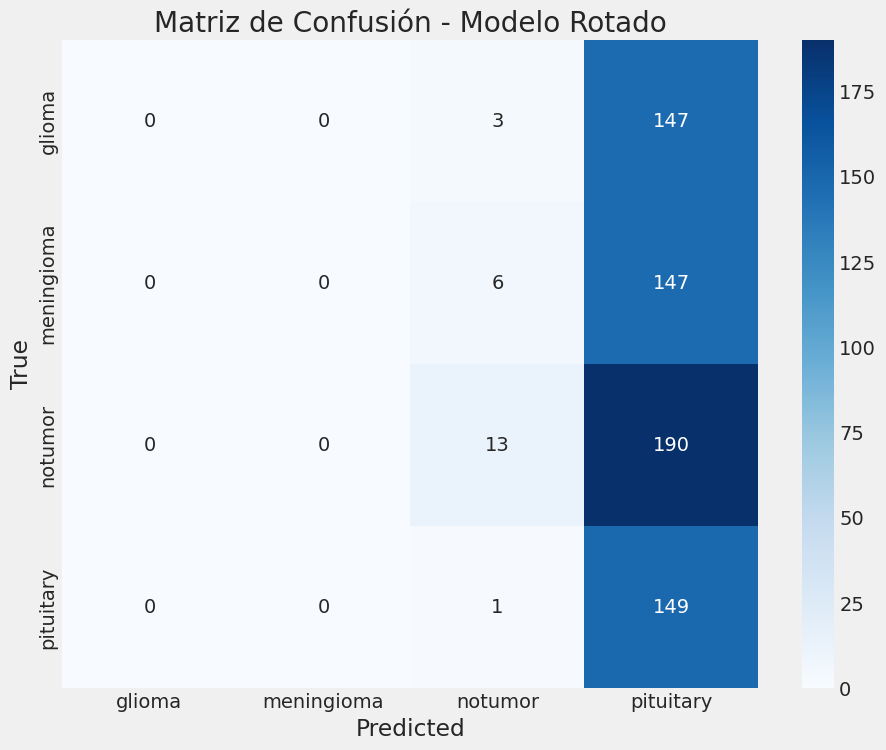

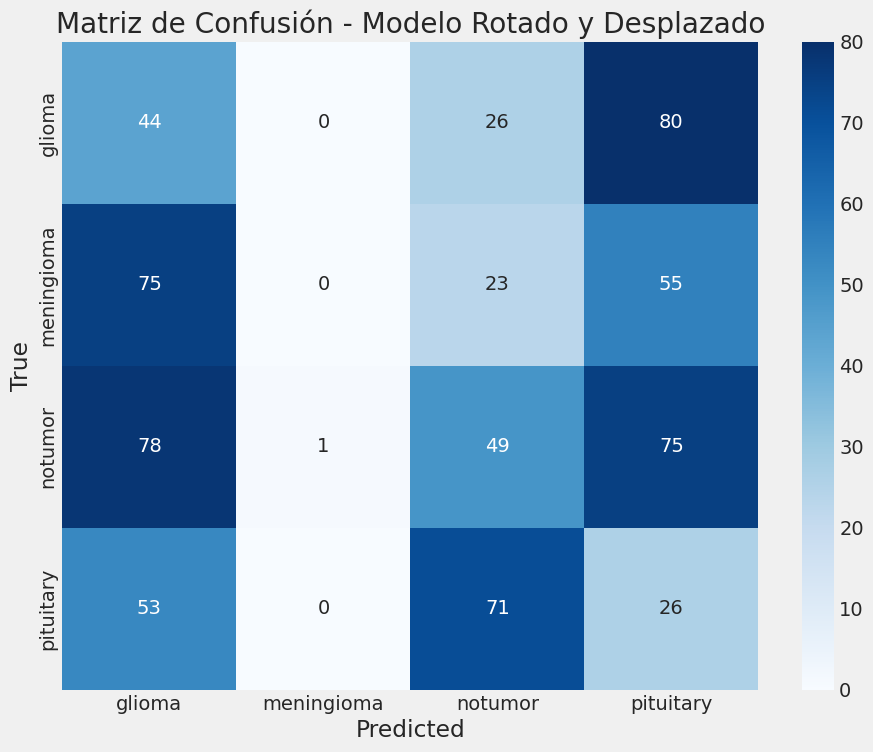

In [57]:

def confusion_matrix_plot(y_predicho, title='Confusion Matrix'):
    cm = confusion_matrix(ts_gen.classes, y_predicho)
    clases= list(ts_gen.class_indices.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

confusion_matrix_plot(y_pred, title='Matriz de Confusión - Modelo Original')
confusion_matrix_plot(y_pred_rotado, title='Matriz de Confusión - Modelo Rotado')
confusion_matrix_plot(y_pred_rotado_shifted, title='Matriz de Confusión - Modelo Rotado y Desplazado')


